# LRC Resonance

### Date: 20/05/19 - 21/05/19
### Group Members: Aayushi Verma, Diana Kommedal, Alex Goodenbour

## Introduction

## Method

## Analysis

### Setup and helper function definition

In [21]:
# Setup and helper function definition

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
from scipy.optimize import minimize
from scipy.stats import chisquare
from decimal import Decimal

# Rounds uncertainties to one significant figure
def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

# Model for a sinusoid
def model_w(params, w):
    I_max, w_0, gamma = params
    return (gamma*w*I_max)/np.sqrt(w**2*gamma**2+(w**2-w_0**2)**2)

# Not sure what the params should be...
def model_C(params, C):
    w = 553*2*np.pi
    R = 21.9014
    L = 0.1479
    V_0 = params
    return (V_0)/np.sqrt(R**2+(w*L-(1/(w*C)))**2)

def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp[i])**2)/(error[i]**2)
    return chisqr

# Function to compute chi-squared
# Last arg is an anonymous function to generalise
def chi2(params, data ,model):
    
    x = data[:,0]
    y = data[:,1]
    err = data[:,2]
    #sigma = data [:,2]
    
    expected = model(params, x)
    #return chisquare(y, expected)[0]
    return chisqr(y, expected, err)

    
# Fits data points to sinusoidal model
# Example:  # params, unc = calc_model(guesses, np.column_stack((w, I)))
def calc_model(guesses, pnts, fn):
    result = minimize(chi2,guesses, method='BFGS',args=(pnts,fn))
    param_unc = np.sqrt(2*np.diag(result.hess_inv))
    newparams = result.x
    #print(newparams)
    return newparams, param_unc

def plot_model(xlow, xhigh, fn, params, label, lstyle="-", colour="c"):
    xx = np.linspace(xlow, xhigh, 1000)
    plt.plot(xx, fn(params, xx), linestyle=lstyle, color=colour, label=label)


# Unit conversion lambdas
in_to_cm = lambda x: 2.54*x

# Importing the data
data = pds.read_csv("lrc.csv")

### Inductance of a Coil

In [22]:
V_meas_unc = 0.1
I_meas_unc = 0.1e-3
w_meas_unc = 1*2*np.pi

L_from_res = lambda w_0, C: 1/(w_0**2*C)
r_from_L = lambda N, L, M_0: (2*L)/(N**2*np.pi*M_0)

M_0 = np.pi*4e-7

C = 0.56e-6
w_0 = 553*2*np.pi
N = 1500

L_coil = L_from_res(w_0, C)
L_coil_unc = L_coil*(2*w_meas_unc)/(w_0) # Propagation of Uncertainties (unc in C negligible compared to unc in w)

r_coil = r_from_L(N, L_coil, M_0)
r_coil_unc = r_coil*L_coil_unc/L_coil

print("Inductance of Coil:", round(L_coil,4),"±", round_to_1(L_coil_unc),"H")
print("Average Radius of Coil: ", round(r_coil*1e2, 4), "±", round_to_1(r_coil_unc), "cm")

Inductance of Coil: 0.1479 ± 0.0005 H
Average Radius of Coil:  3.3303 ± 0.0001 cm


### Resonance Curves

I_max Experimental: 87.7 ± 0.1 mA
w_0 Experimental: 552.01 ± 0.01 Hz
Gamma Experimental: 150.2 ± 0.5

Experimental Resistance: 22.2 ± 0.1 Ω
[0.00085728]

Experimental V_0:  1.9111 ± 0.0009 V


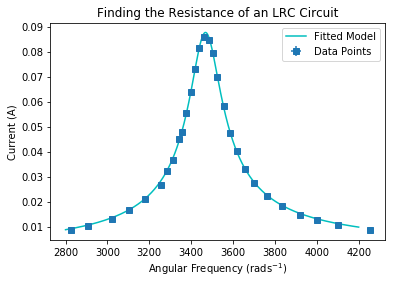

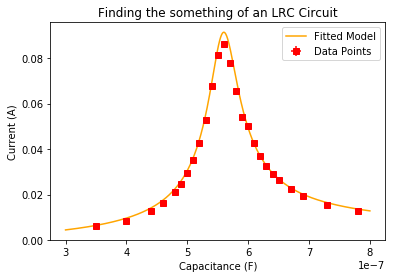

In [32]:
## For I(w) and I(C)

xx = np.linspace(0,10,1000)
#plt.plot(xx, model_w((1,1,1),xx))

w = np.array(data.frequency_w)*np.pi*2
w = w[~np.isnan(w)]
I = np.array(data.current_w)*1e-3
I = I[~np.isnan(I)]

guesses = (85e-3,3500,L_coil*1000)

params, unc = calc_model(guesses, np.column_stack((w,I, (I**0)*I_meas_unc)), model_w)
unc1 = unc
#print("Fitted Params: ", params)

plt.figure(1)

plot_model(2800, 4200, model_w, params, "Fitted Model")
plt.errorbar(w, I, (I**0)*I_meas_unc, 0, linestyle="none", marker="s", label="Data Points")
plt.title("Finding the Resistance of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")
plt.legend()

[I_max_exp, w_0_exp, gamma_exp] = params
#print(unc)
print("I_max Experimental:", round(Decimal(I_max_exp*1e3),1),"±", round_to_1(unc[0]*1e3) ,"mA")
print("w_0 Experimental:", round(Decimal(w_0_exp/(2*np.pi)),2), "±", round_to_1(unc[1]/(2*np.pi)),"Hz")
print("Gamma Experimental:", round(Decimal(gamma_exp),1), "±", round_to_1(unc[2]))
print()
R_exp = gamma_exp*L_coil
R_exp_unc = np.sqrt((L_coil*unc[2])**2+(gamma_exp*L_coil_unc)**2)
print("Experimental Resistance:", round(R_exp,1),"±", round_to_1(R_exp_unc),"Ω")


plt.figure(2)

cap = np.array(data.cap_c)*1e-6
cap = cap[~np.isnan(cap)]
I_c = np.array(data.current_c)*1e-3
I_c = I_c[~np.isnan(I_c)]

guesses = (2)

params, unc = calc_model(guesses, np.column_stack((cap,I_c, (I_c**0)*I_meas_unc)), model_C)
print(unc)
#print("Fitted Params: ", params)

plot_model(0.0000003, 0.0000008, model_C, guesses, "Fitted Model", colour="orange")
plt.errorbar(cap, I_c, (I_c**0)*I_meas_unc, 0, linestyle="none", marker="s", color="r", label="Data Points")
plt.title("Finding the something of an LRC Circuit")
plt.xlabel("Capacitance (F)")
plt.ylabel("Current (A)")
print()
#print(unc)
print("Experimental V_0: ", round(Decimal(params[0]),4),"±", round_to_1(unc[0]), "V")
plt.legend()

### Determination of $Q$

In [29]:
## From Q = V_C / V_S
## and from Q = w_0/gamma from fitted params

Q_exp_1 = data.v_c[0]/data.v_s[0]
Q_exp_1_unc = np.sqrt((1+data.v_c[0])/data.v_s[0])*V_meas_unc

Q_exp_2 = w_0_exp/gamma_exp
Q_exp_2_unc = np.sqrt(((1/gamma_exp)*(unc1[1]))**2+(Q_exp_2*(1/gamma_exp)*(unc1[2]))**2)

print("Experimental Q from Voltage Ratio:", round(Q_exp_1,1), "±", round_to_1(Q_exp_1_unc))
print("Experimental Q from fitted values:", round(Q_exp_2,2), "±", round_to_1(Q_exp_2_unc))

Experimental Q from Voltage Ratio: 22.7 ± 0.5
Experimental Q from fitted values: 23.08 ± 0.07


### Altering $Q$ by Adding Resistance

Total Resistance needed in circuit: 102.60 Ω
Resistance Needed in Variable Resistor: 80.38 Ω
Gamma Experimental: 679.08 ± 4.0

Experimental Resistance: 100.44 ± 0.7 Ω
Experimental Quality Factor: 5.11 ± 0.03


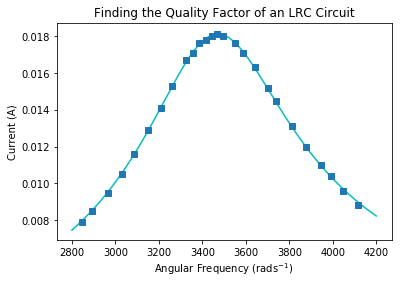

In [26]:
R_5 = (w_0_exp*L_coil)/5
print("Total Resistance needed in circuit:", round(Decimal(R_5),2), "Ω")
R_var_res = R_5-R_exp
print("Resistance Needed in Variable Resistor:", round(Decimal(R_var_res),2), "Ω")

w_5 = np.array(data.freq_5)*np.pi*2
w_5 = w_5[~np.isnan(w_5)]
I_5 = np.array(data.current_5)*1e-3
I_5 = I_5[~np.isnan(I_5)]

guesses = (0.02,3500,L_coil*1000)

params5, unc = calc_model(guesses, np.column_stack((w_5,I_5, (I_5**0)*I_meas_unc)), model_w)
#print("Fitted Params: ", params)

#plt.figure(1)

plot_model(2800, 4200, model_w, params5, "Fitted Model")
plt.errorbar(w_5, I_5, (I_5**0)*I_meas_unc, 0, linestyle="none", marker="s", label="Data Points")
plt.title("Finding the Quality Factor of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")

[I_max_exp_5, w_0_exp_5, gamma_exp_5] = params5

Q_exp_5 = w_0_exp_5/gamma_exp_5
Q_exp_5_unc = np.sqrt(((1/gamma_exp_5)*(unc[1]))**2+(Q_exp_5*(1/gamma_exp_5)*(unc[2]))**2)

print("Gamma Experimental:", round(Decimal(gamma_exp_5),2), "±", round_to_1(unc[2]))
print()
R_exp_5 = gamma_exp_5*L_coil
R_exp_5_unc = np.sqrt((L_coil*unc[2])**2+(gamma_exp_5*L_coil_unc)**2)
print("Experimental Resistance:", round(Decimal(R_exp_5),2),"±",round_to_1(R_exp_5_unc),"Ω")
print("Experimental Quality Factor:", round(Decimal(Q_exp_5),2), "±", round_to_1(Q_exp_5_unc))

###  Resonant Frequency of a Lossy Resonant Circuit

In [27]:
w_d_109 = data.f_109[0]*2*np.pi
v_c_109 = data.v_c_109[0]

w_0_109 = w_d_109*np.sqrt(1+(1/2*Q_exp_5)**2)

observed_difference = np.abs(w_d_109-w_0_exp_5)
print(observed_difference)

27.599429970902747


## Discussion

## Conclusion